In [133]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import glob
import matplotlib.pyplot as plt
from matplotlib import dates
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMAResults
#pip install pmdarima
import pmdarima
from pmdarima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#### We are going to look in your current folder for all the .csv files (you should have your .csv files in the same folder as your notebook) and save their content into a dataframe

In [3]:
file_list = list(glob.iglob('*.csv'))
file_list.sort(reverse=True)

li = []

for filename in file_list:
    df = pd.read_csv(filename, index_col='Datetime', header=0, parse_dates=True)
    li.append(df)
frame = pd.concat(li, axis=0)

In [4]:
file_list

['webfilternew_cleaned.csv',
 'webfilter_cleaned.csv',
 'listnew_cleaned.csv',
 'ipsnew_cleaned.csv',
 'ips_cleaned.csv']

In [5]:
frame.drop(columns='Unnamed: 0', inplace = True)

#### We are creating a new column in the dataframe and initializing it with 1, which will be useful when determining the number of grouped occurences

In [6]:
frame['count'] = 1

In [7]:
frame.index

DatetimeIndex(['2020-01-31 10:14:44', '2020-01-31 10:14:43',
               '2020-01-31 10:14:43', '2020-01-31 10:14:42',
               '2020-01-31 10:14:42', '2020-01-31 10:14:42',
               '2020-01-31 10:14:42', '2020-01-31 10:14:41',
               '2020-01-31 10:14:42', '2020-01-31 10:14:41',
               ...
               '2020-06-21 21:43:26', '2020-06-21 23:38:12',
               '2020-06-22 01:17:43', '2020-06-22 01:39:21',
               '2020-06-22 02:46:40', '2020-06-22 03:14:44',
               '2020-06-22 04:32:38', '2020-06-22 10:50:21',
               '2020-06-22 10:50:21', '2020-06-22 11:21:23'],
              dtype='datetime64[ns]', name='Datetime', length=2398083, freq=None)

# DAILY DATA

#### We are creating a new dataframe in which we will store and count how many times the event occured grouped by date

In [89]:
df_date = frame.groupby(pd.DatetimeIndex(frame.index).date).agg('count')
df_date.index = pd.to_datetime(df_date.index)
df_date.index

DatetimeIndex(['2019-12-08', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13', '2019-12-14', '2019-12-15',
               '2019-12-16', '2019-12-17',
               ...
               '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16',
               '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20',
               '2020-06-21', '2020-06-22'],
              dtype='datetime64[ns]', length=133, freq=None)

#### We need to set the frequency of the index in order to be able to use it in our prediction

In [90]:
df_date = df_date.asfreq('D')

In [91]:
df_date.index

DatetimeIndex(['2019-12-08', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13', '2019-12-14', '2019-12-15',
               '2019-12-16', '2019-12-17',
               ...
               '2020-06-13', '2020-06-14', '2020-06-15', '2020-06-16',
               '2020-06-17', '2020-06-18', '2020-06-19', '2020-06-20',
               '2020-06-21', '2020-06-22'],
              dtype='datetime64[ns]', length=198, freq='D')

In [92]:
df_date.describe()

,count
count,133.000000
mean,18030.699248
std,58220.989016
min,8.000000
25%,33.000000
50%,55.000000
75%,86.000000
max,456277.000000


#### We are getting rid of the noise present in our data

In [93]:
print(df_date['count'].quantile(0.01))
print(df_date['count'].quantile(0.80))

14.64
125.20000000000023


In [94]:
df_date['count'] = np.where(df_date['count'] >125.59999999999928, 125.000000,df_date['count'])
print(df_date['count'].skew())

0.6410314842906302


In [95]:
df_date.describe()

,count
count,133.000000
mean,63.887218
std,36.680573
min,8.000000
25%,33.000000
50%,55.000000
75%,86.000000
max,125.000000


In [96]:
df_date['count'] = np.where(df_date['count'] == 125.59999999999928, 63.887218,df_date['count'])
print(df_date['count'].skew())

0.6410314842906302


In [97]:
df_date.describe()

,count
count,133.000000
mean,63.887218
std,36.680573
min,8.000000
25%,33.000000
50%,55.000000
75%,86.000000
max,125.000000


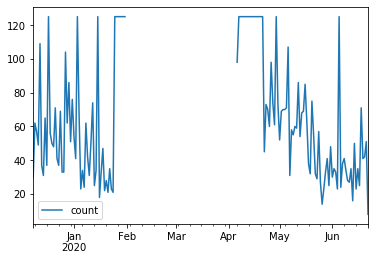

In [98]:
df_date.plot()

In [99]:
df_date.fillna(df_date['count'].mean(), inplace = True)

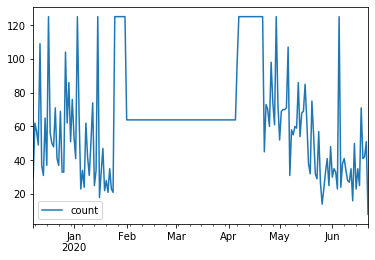

In [100]:
df_date.plot()

In [101]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(df_date)

(0.09090027380245098, False)

#### The result of the above test implies the series is not stationary which implies we will be using the Integrated concept,
#### denoted by the d value.

/Users/andreiturbatu/Applications/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


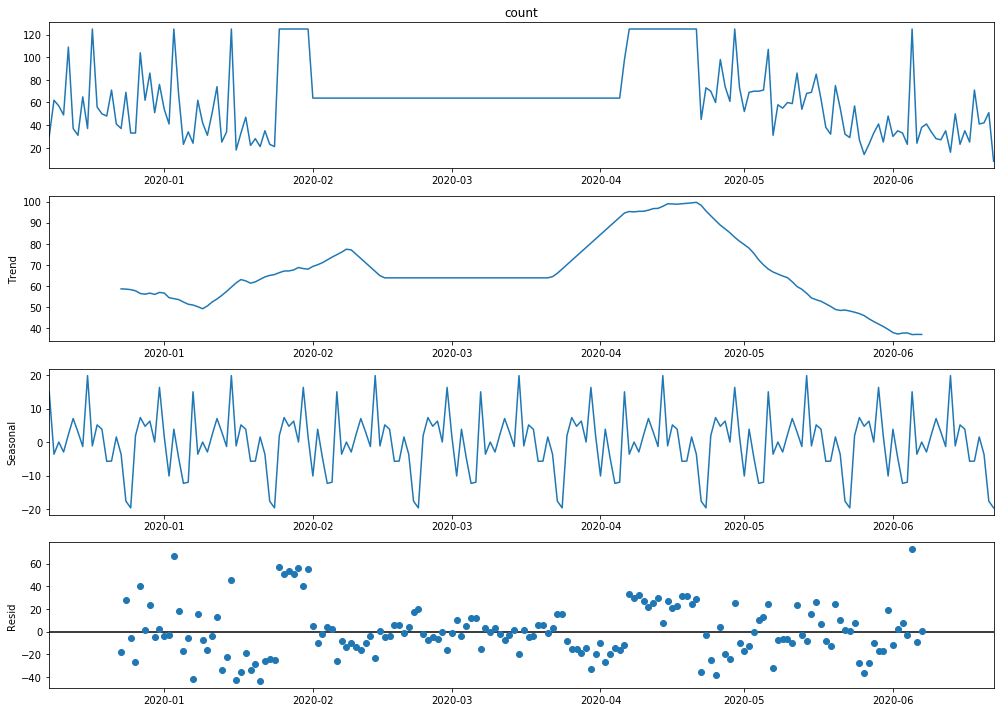

In [102]:
result = seasonal_decompose(df_date['count'], model='add',freq=30)
plt.rcParams['figure.figsize'] = (14,10)
result.plot();

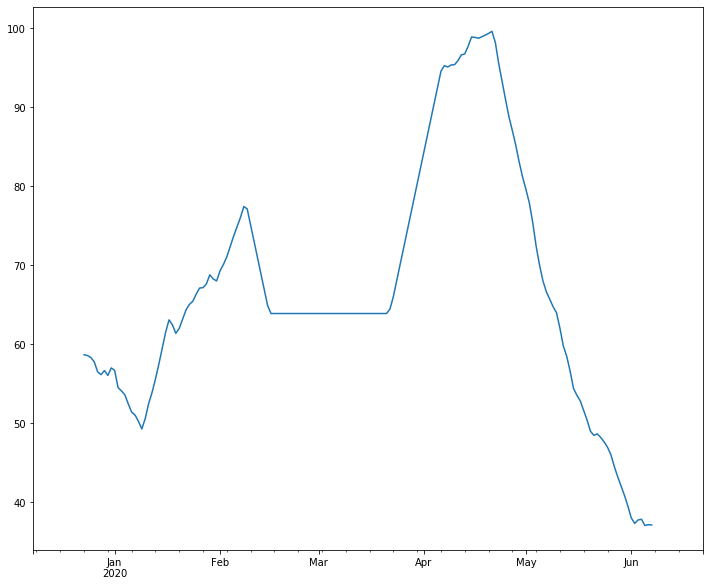

In [104]:
result.trend.plot(figsize=(12,10))

#### We are going to use auto_arima in order to automatically discover the optimal order for the ARIMA model.
#### The auto-ARIMA process seeks to identify the most optimal
#### parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
#### We have already concluded that the d value is going to be used.

# Dending on your computer, running the models will take a while. Please be patient.

In [26]:
auto_arima(df_date['count'], seasonal = True, m=30, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=1822.557, Time=2.12 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=1912.107, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=1843.746, Time=0.69 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=1870.724, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=2249.453, Time=0.01 sec


/Users/andreiturbatu/Applications/anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=1820.475, Time=2.27 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=1818.855, Time=0.20 sec


/Users/andreiturbatu/Applications/anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=1820.534, Time=2.37 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=1817.181, Time=0.13 sec
 ARIMA(1,0,2)(1,0,0)[30] intercept   : AIC=1818.799, Time=1.95 sec
 ARIMA(1,0,2)(0,0,1)[30] intercept   : AIC=1818.793, Time=1.24 sec
 ARIMA(1,0,2)(1,0,1)[30] intercept   : AIC=1820.736, Time=3.29 sec
 ARIMA(0,0,2)(0,0,0)[30] intercept   : AIC=1859.139, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=1816.422, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[30] intercept   : AIC=1818.085, Time=1.30 sec
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=1818.076, Time=0.92 sec


/Users/andreiturbatu/Applications/anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=1868.725, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=1841.755, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=1817.698, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=1825.452, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[30]             : AIC=1822.916, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[30] intercept
Total fit time: 19.360 seconds


ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 0, 30))

In [30]:
train = df_date.iloc[:len(df_date)-60]
test = df_date.iloc[len(df_date)-60:]

# Dending on your computer, running the models will take a while. Please be patient.

In [58]:
model = SARIMAX(train['count'], order= (1,0,1), seasonal_order=(0, 0, 5, 30))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  count   No. Observations:                  138
Model:                     ARMA(1, 1)   Log Likelihood                -629.427
Method:                       css-mle   S.D. of innovations             23.102
Date:                Wed, 11 Nov 2020   AIC                           1266.854
Time:                        08:38:23   BIC                           1278.563
Sample:                    12-08-2019   HQIC                          1271.613
                         - 04-23-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          68.8616      7.632      9.022      0.000      53.902      83.821
ar.L1.count     0.8639      0.058     14.929      0.000       0.750       0.977
ma.L1.count    -0.4514      0.098     -4.622      0.000      -0.643      -0.260
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1575           +0.0000j            1.1575            0.0000
MA.1            2.2152           +0.0000j            2.2152            0.0000
-----------------------------------------------------------------------------
"""

In [36]:
start = len(train)
end = len(train) + len(test) -1 

In [60]:
predictions = results.predict(start, end, type='levels').rename('SARIMA Test Predictions')

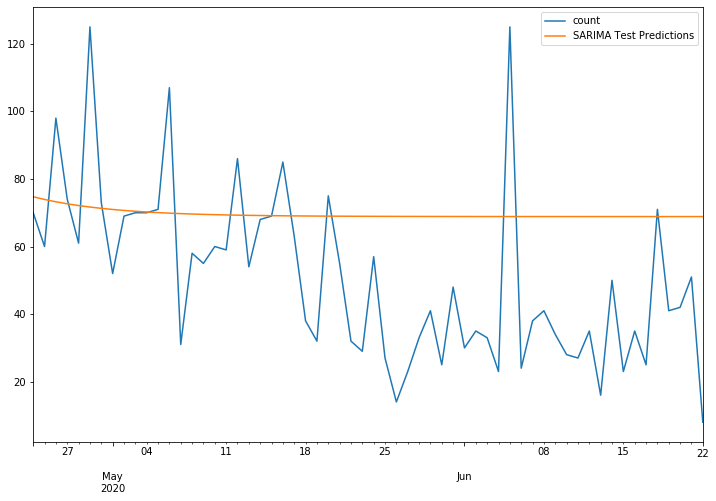

In [61]:
test['count'].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

#### Calculating the  root-mean-square error (RMSE) which is a frequently used to #### measure the differences between values 
#### (sample or population values) predicted by a model or an estimator and the #### values observed

In [130]:
rmse(test['count'], predictions)

31.077556812068703

# Dending on your computer, running the models will take a while. Please be patient.

In [73]:
model = SARIMAX(df_date['count'], order= (3,1,1), seasonal_order=(0, 0, 5, 30), trace=True)
results = model.fit()
fcast = results.predict(len(df_date)-90, len(df_date) +90, type='levels').rename('SARIMA forecast')

/Users/andreiturbatu/Applications/anaconda/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


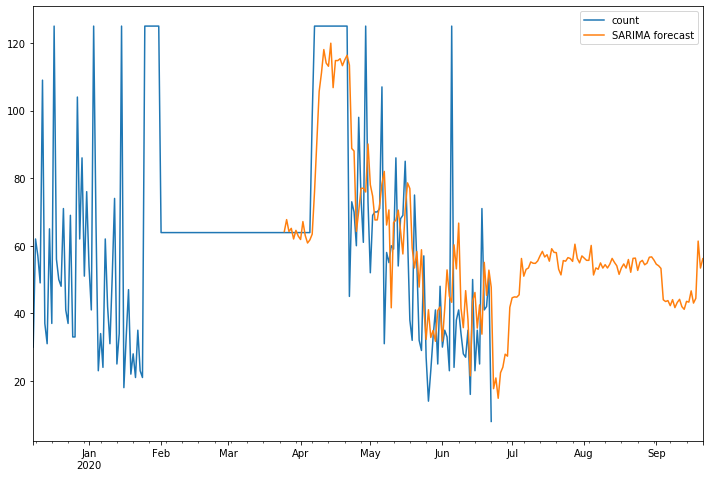

In [74]:
df_date['count'].plot(figsize=(12,8), legend=True)
fcast.plot(legend=True)

#### Calculating the  root-mean-square error (RMSE) which is a frequently used to 
#### measure the differences between values 
#### (sample or population values) predicted by a model or an estimator and the 
#### values observed in reference to the entire data set

In [129]:
rmse(df_date['count'].iloc[17:], fcast)

38.5480471296875

#### Creating a single dataframe in which we store the results predicted next to our actual data

In [119]:
df_result = pd.merge(df_date, fcast, how='outer', left_index=True, right_index=True)

In [124]:
df_result.iloc[-120:-60]

,count,SARIMA forecast
2020-05-25,27.0,32.282151
2020-05-26,14.0,41.067751
2020-05-27,23.0,32.847923
2020-05-28,33.0,34.924902
2020-05-29,41.0,31.716777
2020-05-30,25.0,40.825960
2020-05-31,48.0,41.891920
2020-06-01,30.0,31.767397
2020-06-02,35.0,41.452088
2020-06-03,33.0,52.847225
